In [1]:
!python --version

Python 3.12.10


In [2]:
import numpy as np
import open3d as o3d
import copy

def scale_mesh_to_unit_size(obj_path: str, center=True):
    mesh = o3d.io.read_triangle_mesh(obj_path)
    mesh = copy.deepcopy(mesh)

    if center:
        mesh.translate(-mesh.get_center())

    bbox = mesh.get_axis_aligned_bounding_box()
    diag = np.linalg.norm(bbox.get_extent())

    if diag == 0:
        raise ValueError("Mesh has zero size (degenerate bounding box).")

    scale_factor = 1.0 / diag
    mesh.scale(scale_factor, center=(0, 0, 0))

    return mesh

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def fpfh_global_stats(fpfh_feature):
    F = np.asarray(fpfh_feature.data).T  # (N, 33)
    mu = F.mean(axis=0)
    sd = F.std(axis=0)
    g = np.hstack([mu, sd])              # (66,)
    # optional normalization
    g = g / (np.linalg.norm(g) + 1e-12)
    return g

In [4]:
import numpy as np
import open3d as o3d
from pathlib import Path
from itertools import chain
from tqdm import tqdm

descriptors = []
names = []

obj_dir = [Path("data/OvisAries"), Path("data/GazellaSubgutturosa")]
files = chain.from_iterable(
    sorted(d.glob("*.obj")) for d in obj_dir
)

labels = []

for obj_path in tqdm(files):
    names.append(f"{obj_path.parent.name}-{obj_path.stem.rsplit('-', 1)[-1]}")
    labels.append(0 if str(obj_path).startswith("data\O") else 1)
    mesh = scale_mesh_to_unit_size(obj_path)
    mesh.compute_vertex_normals()

    pcd = mesh.sample_points_poisson_disk(number_of_points=15000)
    #pcd = mesh.sample_points_uniformly(number_of_points=15000)
    bbox = pcd.get_axis_aligned_bounding_box()
    diag = np.linalg.norm(bbox.get_extent())

    normal_radius = 0.02 * diag   # 2% of size
    fpfh_radius   = 0.05 * diag   # 5% of size
    
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(
            radius=normal_radius,
            max_nn=30
        )
    )

    fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd,
        o3d.geometry.KDTreeSearchParamHybrid(
            radius=fpfh_radius,
            max_nn=100
        )
    )

    F = np.asarray(fpfh.data)
    #print("FPFH shape:", F.shape, "min/max:", F.min(), F.max(), "nonzero:", np.count_nonzero(F))
    descriptor = fpfh_global_stats(F)
    descriptors.append(descriptor)

descriptors = np.vstack(descriptors)
descriptors

<>:19: SyntaxWarning: invalid escape sequence '\O'
<>:19: SyntaxWarning: invalid escape sequence '\O'
C:\Users\schueler\AppData\Local\Temp\ipykernel_10176\3866231915.py:19: SyntaxWarning: invalid escape sequence '\O'
  labels.append(0 if str(obj_path).startswith("data\O") else 1)
85it [10:01,  7.08s/it]


array([[0.00000000e+00, 0.00000000e+00, 5.22347650e-04, ...,
        2.93791935e-02, 1.28753898e-02, 1.41348710e-03],
       [2.30017234e-06, 1.74300888e-06, 2.42890795e-04, ...,
        2.36732073e-02, 7.72119559e-03, 1.20386416e-04],
       [3.45155663e-04, 7.02466985e-05, 6.47856978e-04, ...,
        3.30816329e-02, 1.44422800e-02, 3.14013262e-03],
       ...,
       [9.39783543e-05, 2.69148217e-04, 8.91326476e-04, ...,
        3.90262209e-02, 1.58581727e-02, 9.69048558e-03],
       [2.34865868e-05, 1.09121111e-05, 3.64332091e-04, ...,
        3.57106444e-02, 1.17452589e-02, 4.96214325e-04],
       [1.75604897e-04, 6.31465325e-05, 1.07326012e-03, ...,
        3.37211713e-02, 1.49710427e-02, 5.49636889e-03]])

In [5]:
X = descriptors.astype(np.float64)

# Optional but recommended: normalize each descriptor (reduces magnitude effects)
X = X / np.linalg.norm(X, axis=1, keepdims=True)

# Pairwise Euclidean distances, shape (N, N)
D = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=2)
S = 1.0 / (1.0 + D)
print(S)

[[1.         0.97260203 0.96588915 ... 0.92052477 0.92839889 0.93312873]
 [0.97260203 1.         0.95488488 ... 0.90638922 0.91379509 0.91894284]
 [0.96588915 0.95488488 1.         ... 0.94009041 0.94223969 0.94877569]
 ...
 [0.92052477 0.90638922 0.94009041 ... 1.         0.9697282  0.96695407]
 [0.92839889 0.91379509 0.94223969 ... 0.9697282  1.         0.97226022]
 [0.93312873 0.91894284 0.94877569 ... 0.96695407 0.97226022 1.        ]]


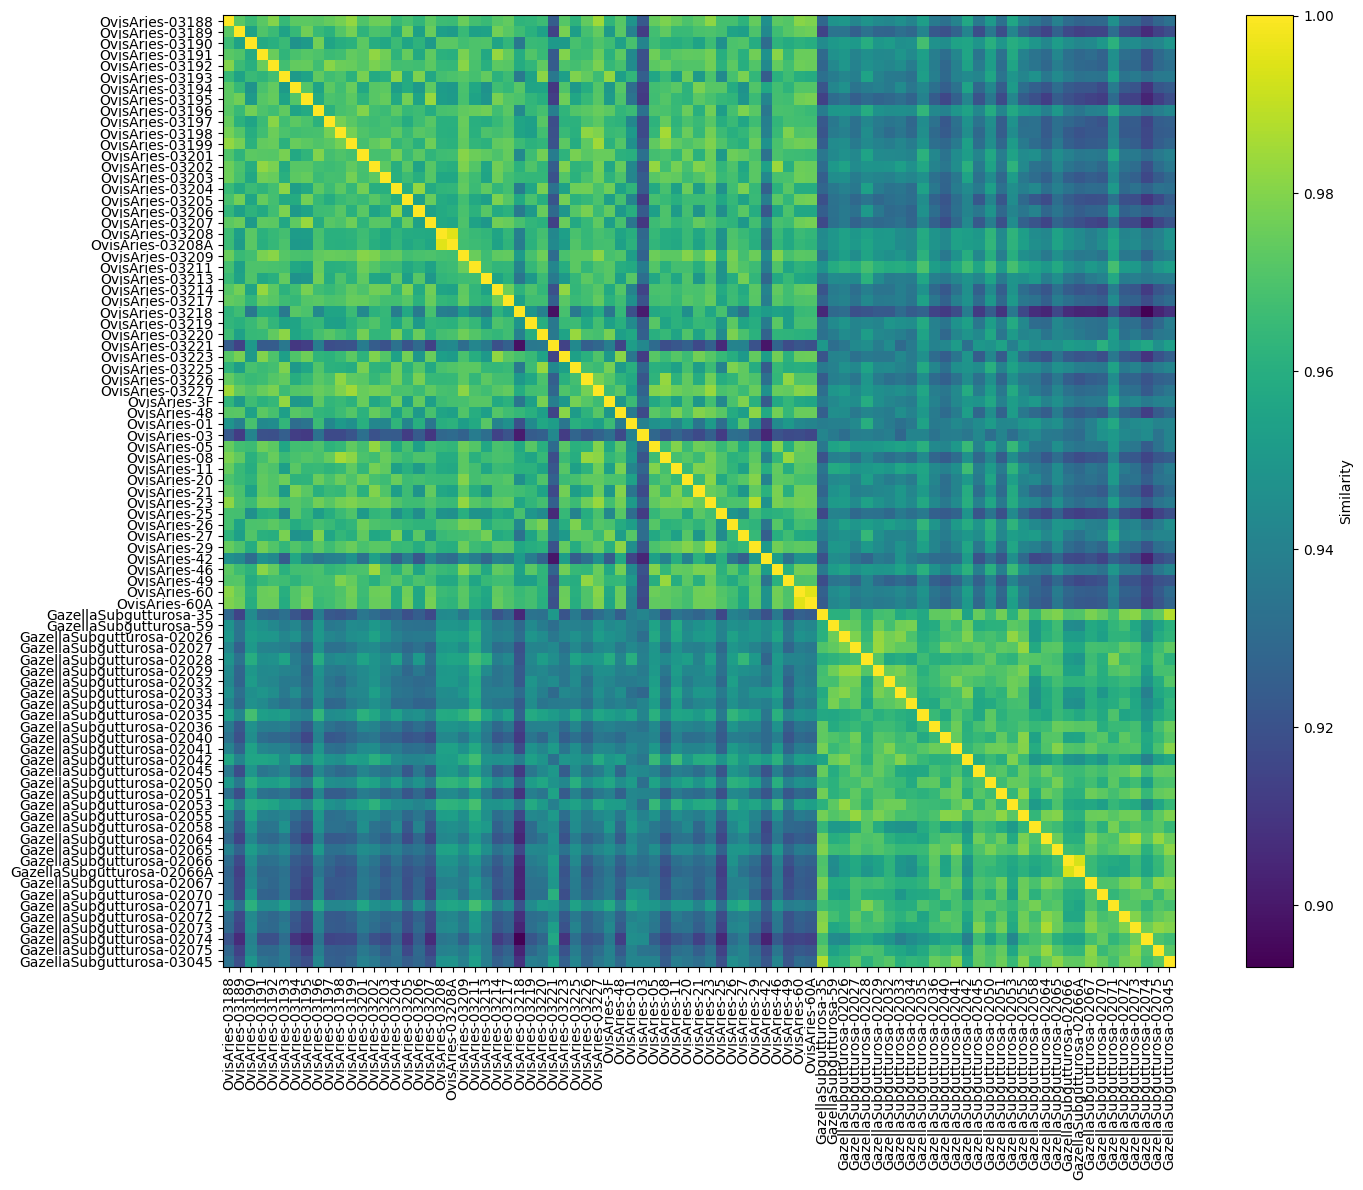

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 12))

im = ax.imshow(S, interpolation="nearest")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Similarity") # (1 / (1 + distance))")

#ax.set_title("Pairwise Similarity of Zernike descriptors")
#ax.set_xlabel("Scan")
#ax.set_ylabel("Scan")

# Tick labels (optional: for many items, this gets crowded)
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticklabels(names)

plt.tight_layout()
#plt.savefig("pairwise_similarity_fpfh-10000-uni.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [7]:
from sklearn.metrics import silhouette_score

# D must be symmetric, zeros on diagonal
score = silhouette_score(D, labels, metric="precomputed")
print(score)

0.4210170828416089


In [8]:
# 0.23497897688104044 mit samplesize 100.000
# 0.3559429291349628 mit samplesize 30.000
# 0.4210170828416089 mit samplesize 15.000  -- takes 10:01 min
# 0.3930161211076321 mit samplesize 15,000 and uniform
# 0.40566948744042847 mit samplesize 10.000   
# 0.364073976001672 mit samplesize 10,000 and uniform
# 0.3367903223452646 mit samplesize 3.000

In [9]:
# Save Descriptor for Classification
np.savez(
    "Descriptors/features_FPFH_sampS15000.npz",
    X=X,
    y=labels,
    ids=names
)
print("Saved")

Saved
